In [5]:
# Tapes preprocessing script

# load in necessary libraries
import h5py
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import welch, iirnotch, filtfilt, butter, lfilter, iirfilter
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [6]:
# Functions to remove noise from EMG signals

def open_hdf5_file(file_path, dataset_name, mode='r'):
    hdf5_file = h5py.File(file_path, mode)
    if dataset_name in hdf5_file:
        dataset = hdf5_file[dataset_name]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not found in the file.")
    return hdf5_file, dataset


def bandpower_ratio(signal, fs, low=10, high=450): #changing from 20, 450
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    total_power = np.trapz(Pxx, f)
    emg_power = np.trapz(Pxx[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)])
    return emg_power / total_power

def notch_filter(data, fs, f0, Q=30.0):
    """
    Create and apply a notch filter that is compatible with both older and newer
    SciPy signatures for iirnotch.

    Newer SciPy: iirnotch(w0, Q, fs)
    Older SciPy: iirnotch(w0, Q) where w0 is normalized (0..1) relative to Nyquist.
    """
    try:
        # Try newer signature first (w0 in Hz, pass fs)
        b, a = iirnotch(f0, Q, fs)
    except TypeError:
        # Fall back to older signature: normalize f0 by Nyquist (fs/2)
        w0 = f0 / (fs / 2.0)
        b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data)


def remove_odd_harmonics(data, fs, f0=50.0, harmonics=5, Q=30.0):
    filtered_data = data
    for k in range(1, harmonics + 1, 2):  # Only odd harmonics (1, 3, 5, ...)
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data


def remove_harmonics(data, fs, f0=50.0, harmonics=9, Q=30.0): #changing this from 5 to 9, bc i'm lowpassing at 450hz instead of 150hz
    filtered_data = data
    for k in range(1, harmonics + 1):  # All harmonics
        harmonic_freq = f0 * k
        if harmonic_freq < fs / 2:  # Ensure it is within Nyquist frequency
            filtered_data = notch_filter(filtered_data, fs, harmonic_freq, Q)
    return filtered_data


def feed_forward_comb_filter(signal, delay, alpha):
    """
    Apply a feed-forward comb filter to the input signal.
    Parameters:
    signal (numpy.ndarray): Input EMG signal.
    delay (int): Delay in samples. fs/freq
    alpha (float): Feedback gain factor. -1
    Returns:
    numpy.ndarray: Filtered signal.
    """
    # Initialize the output array with the same length as the input signal
    filtered_signal = np.zeros_like(signal)
    # Apply the comb filter
    for n in range(len(signal)):
        if n >= delay:
            filtered_signal[n] = signal[n] + alpha * signal[n - delay]
        else:
            filtered_signal[n] = signal[n]  # No delay possible for the initial samples
    return filtered_signal


def butter_highpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data


def butter_lowpass(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = scipy.signal.filtfilt(b, a, data)
    return filtered_data


In [4]:
# setting up directories and parameters
#subs   = ['07', '08', '09', '10', '11', '12', '13', '14', '15'] # ['16', '17', '18', '19', '20', '21']  
subs = ['23']
days = ['1']
#days   = ['1','2','3','4','5']            
tasks = ["Tapes", "Tapes_standing", "Tapes_cog_load"]  
trials = range(1, 6)  # Raw_emg_1 ... Raw_emg_5

dataset_name = "rawEMG"

# assign variables
fs = 2000  # Hz
freq = 50
delay = int(fs / freq)  # Delay to target the frequency of the sine wave
alpha = -1  # Feedback gain factor
highpass_filt = 10
lowpass_filt = 450
snr_thresh = 0.6
z_thresh   = 3.0

#directory paths 
baseDir = Path("/Volumes/LaCie/ResearchProjects/Null_Space_EMG")
# dayDir  = baseDir + f"/PT_{sub}/PT_{sub}_Day{day}/"
# task_list = tasks if isinstance(tasks, (list, tuple)) else [tasks]
# taskDir = []
# for task in task_list:
#     taskDir += sorted([p for p in Path(dayDir).glob(f"*/{task}") if p.is_dir()])
out_csv = Path(baseDir) / "noisy_channels.csv"

# Setting up ordering of EMG channels
# old order (PT_7-15)
# flexors     = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8]
# extensors   = [57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53]
# bicep       = [22,21,20,19,18,17,25,26,27,28,29,30]
# lateral_tri = [40,32,38,36,31,39,37,35]
# long_tri    = [47,46,45,49,48,52,51,50]

# #new order (PT_16-21)
flexors = [25,26,27,28,29,30,31,32,17,18,19,20,21,22,23,24,9,10] # the 8 is renamed to 10 bc sensors have 2 8s
extensors = [11,12,13,14,15,16,1,2,3,4,5,6,7,52,8,49,50,51]
bicep = [40,39,38,37,36,35,34,33,48,47,46,45]
lateral_tri = [42,43,41,56,47,55,54,53]
long_tri = [62,63,64,60,61,57,58,59]

desired_order = flexors + extensors + bicep + lateral_tri + long_tri  # 1..64
reorder_idx0  = [e - 1 for e in desired_order]  # 0-based indices for numpy

# muscle group map for CSV (keys are ORIGINAL 1-based channel labels)
muscle_map = {ch: "flexors" for ch in flexors}
muscle_map |= {ch: "extensors" for ch in extensors}
muscle_map |= {ch: "bicep" for ch in bicep}
muscle_map |= {ch: "lateral_tri" for ch in lateral_tri}
muscle_map |= {ch: "long_tri" for ch in long_tri}

# New-label to original-label mapping
new_channel_labels = list(range(1, 65))                         # 1..64 (reordered space)
new_to_old = dict(zip(new_channel_labels, desired_order))       # new -> original
old_to_new = {old: new for new, old in new_to_old.items()}      # original -> new
new_muscle_map = {new: muscle_map[new_to_old[new]] for new in new_channel_labels}


# ---- Start preprocessing over subs and sess ----
for sub in subs:
    for day in days:
        # Day folder like .../PT_07/PT_07_Day1
        dayDir = baseDir / f"PT_{sub}" / f"PT_{sub}_Day{day}"

        # For each requested task, find any session folder (.../PT_*/*/<task>)
        all_task_dirs = []
        for task in tasks:
            all_task_dirs += [p for p in dayDir.glob(f"*/{task}") if p.is_dir()]

        for task_dir in sorted(all_task_dirs):
            task = task_dir.name                     # 'Tapes', 'Tapes_standing', etc.
            session_name = f"Day{day}"          

            for trial in trials:
                fpath = task_dir / f"Raw_emg_{trial}.hdf5"
                 # --- skip missing files quickly ---
                if not fpath.exists():
                    print(f"⚠️ Missing file: {fpath}")
                    continue

                try:
                    h5, dset = open_hdf5_file(str(fpath), dataset_name, mode='r')
                    data = np.array(dset[:])
                    h5.close()
                except FileNotFoundError:
                    print(f"⚠️ File not found (skipping): {fpath}")
                    continue
                except OSError as e:
                    print(f"⚠️ Unable to open {fpath}: {e}")
                    continue

                # --- READ emg files ---
                h5, dset = open_hdf5_file(str(fpath), dataset_name, mode='r')
                data = np.array(dset[:])  # (time, 64)
                h5.close()

                # --- REORDER TO CANONICAL LAYOUT ---
                data = data[:, reorder_idx0]  # now cols are new labels 1..64

                # --- FILTER ---
                filtered_x = np.empty_like(data)
                for i in range(data.shape[1]):
                    x = data[:, i]
                    x = butter_highpass(x, highpass_filt, fs)
                    x = butter_lowpass(x,  lowpass_filt,  fs)
                    x = remove_harmonics(x, fs)
                    filtered_x[:, i] = x

                # --- QC METRICS ---
                snr_per_ch = np.array([bandpower_ratio(filtered_x[:, i], fs)
                                       for i in range(64)])
                rms = np.sqrt(np.mean(filtered_x**2, axis=0))
                rms_z = (rms - rms.mean()) / (rms.std() + 1e-12)

                low_snr_idx = np.flatnonzero(snr_per_ch < snr_thresh)
                rms_out_idx = np.flatnonzero(np.abs(rms_z) > z_thresh)
                bad_idx = np.union1d(low_snr_idx, rms_out_idx)       # 0-based in reordered space

                # --- Build rows for CSV (NEW labels + reason) ---
                bad_info = []
                for idx in bad_idx:
                    new_label = idx + 1                               # 1..64 in reordered space
                    muscle = new_muscle_map[new_label]
                    reasons = []
                    if snr_per_ch[idx] < snr_thresh:
                        reasons.append(f"low SNR ({snr_per_ch[idx]:.2f})")
                    if abs(rms_z[idx]) > z_thresh:
                        reasons.append(f"RMS z={rms_z[idx]:.2f}")
                    bad_info.append({
                        "SubjectID": f"PT_{sub}",
                        "Day": int(day),
                        "Task": task,
                        "Trial": int(trial),
                        #"Session": session_name,
                        "Channel": int(new_label),             # NEW numbering 1..64
                        "Muscle": muscle,
                        "SNR": float(snr_per_ch[idx]),
                        "RMS": float(rms[idx]),
                        "RMS_z": float(rms_z[idx]),
                        "Info": " & ".join(reasons),
                        #"File": str(fpath)
                    })

                # --- Append to CSV ---
                if bad_info:
                    bad_df = pd.DataFrame(bad_info, columns=[
                        "SubjectID","Day","Task","Trial",
                        "Channel","Muscle","SNR","RMS","RMS_z","Info"
                    ])
                    # check for existing CSV
                    write_header = not out_csv.exists()

                    if out_csv.exists():
                        existing = pd.read_csv(out_csv, usecols=["SubjectID","Day","Task","Trial"])
                        # make a flag for this trial
                        already_done = (
                            (existing["SubjectID"] == f"PT_{sub}") &
                            (existing["Day"] == int(day)) &
                            (existing["Task"] == task) &
                            (existing["Trial"] == int(trial))
                        ).any()
                    else:
                        already_done = False

                    if already_done:
                        print(f"⚠️  Skipping PT_{sub} {task} Day{day} Trial {trial} (already in {out_csv.name})")
                    else:
                        bad_df.to_csv(out_csv, mode="a", header=write_header, index=False)
                        print(f"✅ Appended {len(bad_df)} rows → {out_csv.name}")
                else:
                    print(f"OK PT_{sub} {task} Day{day} Trial {trial}: no bad channels")


In [14]:
noisy_channels_df = pd.read_csv(out_csv)
print(noisy_channels_df.shape)
noisy_channels_df.head()

(212, 10)


,SubjectID,Day,Task,Trial,Channel,Muscle,SNR,RMS,RMS_z,Info
0,PT_07,1,Tapes,1,54,lateral_tri,0.980143,534.411133,3.280705,RMS z=3.28
1,PT_07,1,Tapes,5,54,lateral_tri,0.983582,495.966248,3.120497,RMS z=3.12
2,PT_07,3,Tapes,1,35,extensors,0.989781,524.491516,3.153775,RMS z=3.15
3,PT_07,3,Tapes,1,57,long_tri,0.989975,518.382935,3.071229,RMS z=3.07
4,PT_07,5,Tapes,2,7,flexors,NaN,0.000000,-3.046693,RMS z=-3.05


In [13]:
new_to_old[54]

39

In [ ]:

# Load EMG data from HDF5 files
emg_records = []  # will hold dicts with session, trial, path, data array

for task_dir in taskDir:
    session_name = f"Day{day}"   # simple readable label
    for trial in range(1, 6):
        fpath = task_dir / f"Raw_emg_{trial}.hdf5"
        if not fpath.exists():
            continue
        
        # read in hdf files
        h5, dset = open_hdf5_file(str(fpath), dataset_name, mode='r')
        data = np.array(dset[:])
        h5.close()

        # reorder channels to desired order
        # (useing reorder_idx0  defined above)
        reordered_x = data[:, reorder_idx0]
        data = reordered_x  # now canonical order

        

        # store in list
        emg_records.append({
            "session": session_name,     # e.g., 'Day1'
            "trial": trial,
            "path": str(fpath),
            "data": data
        })

        print(f"Loaded: {fpath}  ->  {data.shape}")

print(f"Total files loaded: {len(emg_records)}")



In [67]:
# EMG ordering
# --------------------------------------
# Muscle group lists (1-based channel numbering)
flexors     = [23,24,16,10,9,13,12,11,15,1,14,2,4,3,5,6,7,8]
extensors   = [57,60,61,59,62,58,63,64,55,56,54,34,33,41,42,43,44,53]
bicep       = [22,21,20,19,18,17,25,26,27,28,29,30]
lateral_tri = [40,32,38,36,31,39,37,35]
long_tri    = [47,46,45,49,48,52,51,50]

# Desired reorder (1-based -> we’ll convert to 0-based indices for numpy)
desired_order = flexors + extensors + bicep + lateral_tri + long_tri   # length 64
#reorder_idx0 = [e - 1 for e in desired_order]  # 0-based for numpy

# reorder data
reordered_x = data[:, [e-1 for e in desired_order]]

# make new channel labels 1–64 in the new order
new_channel_labels = list(range(1, 65))

# make a mapping from new number → original channel
new_to_old = dict(zip(new_channel_labels, desired_order))
old_to_new = {v: k for k, v in new_to_old.items()}

# Map original channel -> muscle group (for CSV)
muscle_map = {}
for ch in flexors:     muscle_map[ch] = "flexors"
for ch in extensors:   muscle_map[ch] = "extensors"
for ch in bicep:       muscle_map[ch] = "bicep"
for ch in lateral_tri: muscle_map[ch] = "lateral_tri"
for ch in long_tri:    muscle_map[ch] = "long_tri"

In [ ]:
for rec in emg_records:
    data = rec["data"]
    filtered_x = np.zeros_like(data)

    for i in range(data.shape[1]):
        x = data[:, i]
        x = butter_highpass(x, 10, fs)
        x = butter_lowpass(x, 450, fs)
        x = remove_harmonics(x, fs)
        filtered_x[:, i] = x

    rec["filtered"] = filtered_x  # save back into dict
    print(f"filtered {rec['path']}")


filtered /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_1.hdf5
filtered /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_2.hdf5
filtered /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_3.hdf5
filtered /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_4.hdf5
filtered /Volumes/LaCie/ResearchProjects/Null_Space_EMG/PT_07/PT_07_Day1/PT_07_1_2025_03_17/Tapes/Raw_emg_5.hdf5


In [ ]:
# ---- QC metrics ----
snr_per_ch = np.array([bandpower_ratio(filtered_x[:, i], fs) for i in range(64)])
rms = np.sqrt(np.mean(filtered_x**2, axis=0))
rms_z = (rms - rms.mean()) / (rms.std() + 1e-12)

# ---- thresholds ----
snr_thresh = 0.6
z_thresh   = 3.0

# ---- identify ----
low_snr_idx = np.flatnonzero(snr_per_ch < snr_thresh)
rms_out_idx = np.flatnonzero(np.abs(rms_z) > z_thresh)
bad_idx     = np.union1d(low_snr_idx, rms_out_idx)

bad_new_labels = (bad_idx + 1).tolist()
bad_muscles    = [new_muscle_map[n] for n in bad_new_labels]

# ---- info on why each channel is bad ----
bad_info = []
for idx, label, muscle in zip(bad_idx, bad_new_labels, bad_muscles):
    snr_val = snr_per_ch[idx]
    rms_val = rms[idx]
    z_val   = rms_z[idx]
    reasons = []
    if snr_val < snr_thresh:
        reasons.append(f"low SNR ({snr_val:.2f})")
    if abs(z_val) > z_thresh:
        reasons.append(f"RMS z={z_val:.2f}")
    reason_str = " & ".join(reasons)
    bad_info.append({
        "Channel": int(label),
        "Muscle": muscle,
        "SNR": float(snr_val),
        "RMS": float(rms_val),
        "RMS_z": float(z_val),
        "Bad features": reason_str
    })

# ---- pretty print ----
import pandas as pd
if bad_info:
    bad_df = pd.DataFrame(bad_info)
    print(f"\nBad channel summary for PT_{sub} {task} {session_name} Trial {trial}:")
    print(bad_df.to_string(index=False))
else:
    print("No bad channels detected.")



Bad channel summary for PT_07 Tapes Day1 Trial 5:
 Channel      Muscle      SNR        RMS    RMS_z Bad features
      54 lateral_tri 0.983582 495.966248 3.120497   RMS z=3.12


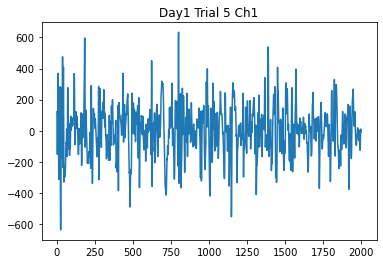

In [62]:
import matplotlib.pyplot as plt
plt.plot(rec["filtered"][:2000, 0])  # first channel, first 2000 samples
plt.title(f"{rec['session']} Trial {rec['trial']} Ch1")
plt.show()


In [ ]:
# filtering data
filtered_x = np.zeros_like(data)
for i in range(64):
    x_data = data[:, i]
    x_data = butter_highpass(x_data, highpass_filt, 2000) # 10 Hz highpass
    x_data = butter_lowpass(x_data, lowpass_filt, 2000) # 450 Hz lowpass 
    x_data = remove_harmonics(x_data,2000)
    filtered_x[:,i] = x_data

# Signal to Noise Ratio
snr_estimates_filtered = [bandpower_ratio(filtered_x[:, i], fs) for i in range(64)]

# Mean Signal to Noise Ratio
mean_snr_estimates_filtered = np.mean([bandpower_ratio(filtered_x[:, i], fs) for i in range(64)])
#print("Mean SNR estimate:", np.mean(mean_snr_estimates_filtered))

# Assessing channels that have SNR less than 0.6
low_snr_idx = np.where(np.array(snr_estimates_filtered) < 0.6)[0]
#print("Channels with SNR < 0.6:", low_snr_idx)

# Calculate RMS per channel
rms_channels = np.sqrt(np.mean(filtered_x**2, axis=0))

# Z-score the RMS values
rms_z = (rms_channels - np.mean(rms_channels)) / np.std(rms_channels)
#print(rms_z)

# Find indices of outliers
outlier_idx = np.where((rms_z > 3) | (rms_z < -3))[0]
#print("Outlier channels (|z| > 3):", outlier_idx)